### In this notebook, we show that diffusion models exhibit increasing linearity as they transition from memorization to generalization

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import zipfile
import PIL.Image
import json
from tqdm import tqdm
import dnnlib
import pickle
from tqdm import tqdm
try:
    import pyspng
except ImportError:
    pyspng = None
import matplotlib.pyplot as plt

/home/forkobe/.conda/envs/edm_orig/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Design basic functions

In [2]:
def load_img_zip(zip_path):
    zip_file = zipfile.ZipFile(zip_path)
    all_names = set(zip_file.namelist())

    PIL.Image.init()
    image_names = sorted(fname for fname in all_names if file_ext(fname) in PIL.Image.EXTENSION)

    images = []    
    # load images
    for name in tqdm(image_names):
        with zip_file.open(name, 'r') as f:
            if pyspng is not None and file_ext(name) == '.png':
                image = pyspng.load(f.read())
            else:
                image = np.array(PIL.Image.open(f))
        if image.ndim == 2:
            image = image[:, :, np.newaxis]  # HW => HWC
        image = image.transpose(2, 0, 1)     # HWC => CHW

        # append images
        images.append(image[np.newaxis, :, :, :])

    images = np.concatenate(images, axis=0)
    N, C, H, W = images.shape
    #y = torch.from_numpy(images).to(torch.float32) / 127.5 - 1
    y = images / 127.5 - 1
    y = y.reshape(N, -1)
    y = np.float32(y)
    return y

def file_ext(fname):
    return os.path.splitext(fname)[1].lower()

def load_ffhq_zip(zip_path):
    zip_file = zipfile.ZipFile(zip_path)
    all_names = set(zip_file.namelist())

    PIL.Image.init()
    image_names = sorted(fname for fname in all_names if file_ext(fname) in PIL.Image.EXTENSION)

    images = []    
    # load images
    for name in tqdm(image_names):
        with zip_file.open(name, 'r') as f:
            if pyspng is not None and file_ext(name) == '.png':
                image = pyspng.load(f.read())
            else:
                image = np.array(PIL.Image.open(f))
        if image.ndim == 2:
            image = image[:, :, np.newaxis]  # HW => HWC
        image = image.transpose(2, 0, 1)     # HWC => CHW

        # append images
        images.append(image[np.newaxis, :, :, :])

    images = np.concatenate(images, axis=0)
    N, C, H, W = images.shape
    y = torch.from_numpy(images).to(torch.float32) / 127.5 - 1
    y = y.reshape(N, C*H*W)
    return y

def normalize_img(img):
    img = img-torch.min(img)
    img = img/torch.max(img)
    return img

def get_denoised_img(noisy_img, net, var, device=torch.device('cuda')):
    # variance should be in the range(0.002,80)
    return net(noisy_img, torch.tensor(var,device=device))

# This dataset contains only images
class Image_Only_Dataset(Dataset):
    def __init__(self, data, device, max_num_images=1000):
        # data is the noisy image, target is the denoised image
        max_num_images = min(len(data), max_num_images)
        self.data = torch.from_numpy(data[:max_num_images,:]).to(device)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
def get_dataloader(data_path, batch_size):
    c = dnnlib.EasyDict()
    c.dataset_kwargs = dnnlib.EasyDict(class_name='training.dataset.ImageFolderDataset', path=data_path, use_labels=False, xflip=False, cache=True)
    c.data_loader_kwargs = dnnlib.EasyDict(pin_memory=True, num_workers=1, prefetch_factor=2)
    dataset_obj = dnnlib.util.construct_class_by_name(**c.dataset_kwargs) # subclass of training.dataset.Dataset
    dataloader = torch.utils.data.DataLoader(dataset=dataset_obj, batch_size=batch_size, shuffle=False)
    return dataset_obj

def cosine_similarity(data, target):
    '''
    x_1: (B,C,H,W)
    x_2: (B,C,H,W)  
    '''
    data = data.reshape(data.shape[0], -1) # (B,N,C*H*W)
    target = target.reshape(target.shape[0], -1) # (B,N,C*H*W)
    inner_product = torch.sum(data*target,dim=-1)
    #print(inner_product.shape)
    norm_data = torch.linalg.norm(data, dim=1)
    norm_target = torch.linalg.norm(target, dim=1)
    #print(norm_x_1.shape)
    return torch.sum(inner_product/(norm_data*norm_target*data.shape[0])).item()

def normalized_difference(data, target):
    # data and target both has size BxHxWxC
    data = data.reshape(data.shape[0],-1)
    target = target.reshape(target.shape[0],-1)
    mse = torch.linalg.norm(target-data,dim=1)
    normalize_factor = torch.linalg.norm(target,dim=1)
    return (torch.sum(mse/normalize_factor)/data.shape[0]).item()

### Construct dataset

In [3]:
device = torch.device('cuda')
max_num_images = 1e9
data_path = 'datasets/celeb_hq_64x64.zip'
dataset_celeb = Image_Only_Dataset(load_img_zip(data_path), device, max_num_images)

100%|██████████| 30000/30000 [00:02<00:00, 11335.14it/s]


### Prepare model

In [127]:
torch.manual_seed(0)
# This model is sufficiently trained on 70000 images
network_pkl = 'Varying_dataset_size/FFHQ/70000_scale_128/edm-ffhq-64x64-uncond-ve.pkl'
print(f'Loading network from "{network_pkl}"...')
with dnnlib.util.open_url(network_pkl) as f:
    net = pickle.load(f)['ema'].to(device)
    
# Construct the discrete timesteps for measuring the linearity
num_steps=40; sigma_min=0.002; sigma_max=80; rho=7
S_churn=0; S_min=0; S_max=float('inf'); S_noise=1
step_indices = torch.arange(num_steps, dtype=torch.float64, device=device)
t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
t_steps = torch.cat([net.round_sigma(t_steps), torch.zeros_like(t_steps[:1])]) # t_N = 0

Loading network from "Varying_dataset_size/FFHQ/70000_scale_128/edm-ffhq-64x64-uncond-ve.pkl"...


### We have two choices for measuring the linearity: (i) directly input noise to the deep network and (ii) input noisy images. We will show both choices lead to the same trend.

### Choice 1: take pure noise as input

/tmp/ipykernel_412733/1948042587.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return net(noisy_img, torch.tensor(var,device=device))


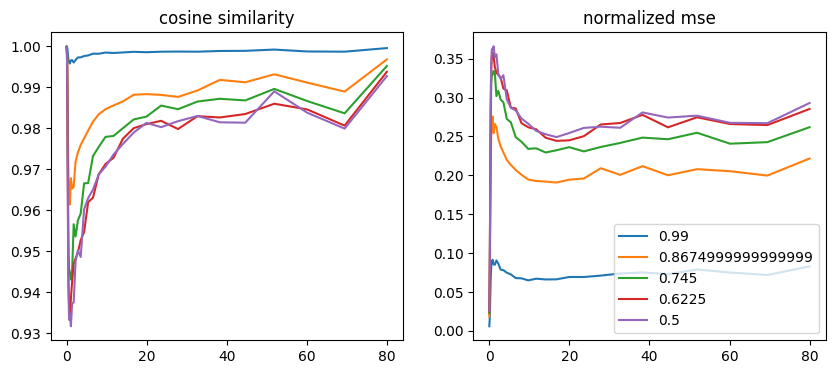

In [129]:
torch.manual_seed(0)

cos_similarity_list_all = []
normalized_mse_list_all = []
# Average over 100 random sampled noise
batch_size = 100
# This corresponding to the alpha and beta parameters of the linearity score defined in the paper
alphas = np.linspace(0.99,1/2,5)
for alpha in alphas:
    cos_similarity_list = []
    normalized_mse_list = []
    for sigma in t_steps:
        noise_1 = sigma*torch.randn(batch_size,3,64,64).to(device)
        noise_2 = sigma*torch.randn(batch_size,3,64,64).to(device)
        denoised_img_1 = get_denoised_img(noise_1, net, sigma)
        denoised_img_2 = get_denoised_img(noise_2, net, sigma)
        noise_additive = np.sqrt(alpha)*noise_1 + np.sqrt(1-alpha)*noise_2
        denoised_img_additive = get_denoised_img(noise_additive, net, sigma)
        cos_similarity_list.append(cosine_similarity(denoised_img_additive, np.sqrt(alpha)*denoised_img_1 + np.sqrt(1-alpha)*denoised_img_2))
        normalized_mse_list.append(normalized_difference(denoised_img_additive, np.sqrt(alpha)*denoised_img_1 + np.sqrt(1-alpha)*denoised_img_2))
    cos_similarity_list_all.append(cos_similarity_list)
    normalized_mse_list_all.append(normalized_mse_list)

# Save the linearity scores
'''
save_dir = 'Linear_Investigation/Pure_Noise'
if os.path.exists(save_dir) == False:
    os.makedirs(save_dir)
torch.save(cos_similarity_list_big, os.path.join(save_dir, 'cos_similarity_list'))
torch.save(normalized_mse_list_big, os.path.join(save_dir, 'normalized_mse_list'))
'''

# Visualize the linearity scores
plt.figure(figsize=(10,4))
for i in range(len(cos_similarity_list_all)):
    plt.subplot(121)
    plt.title('cosine similarity')
    plt.plot(t_steps.cpu(), cos_similarity_list_all[i], label=str(alphas[i]))
    plt.subplot(122)
    plt.title('normalized mse')
    plt.plot(t_steps.cpu(), normalized_mse_list_all[i], label=str(alphas[i]))
plt.legend()
plt.show()

### Visualization

sigma = 80.0


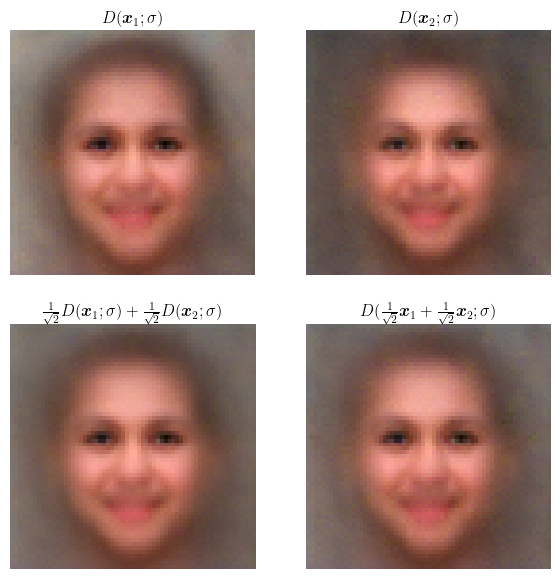

sigma = 42.415189318512674


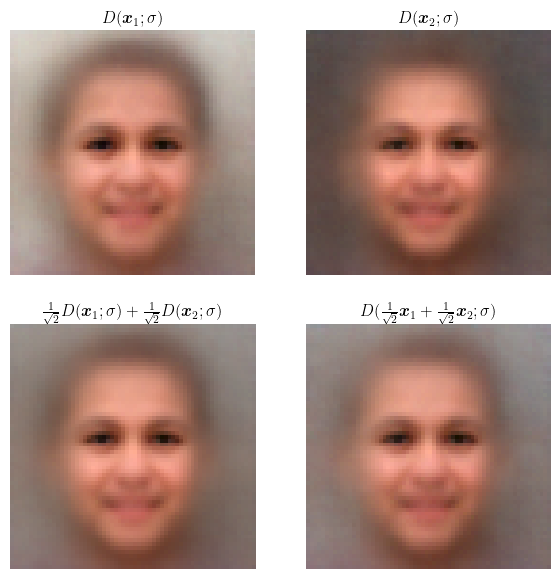

sigma = 21.10867673619376


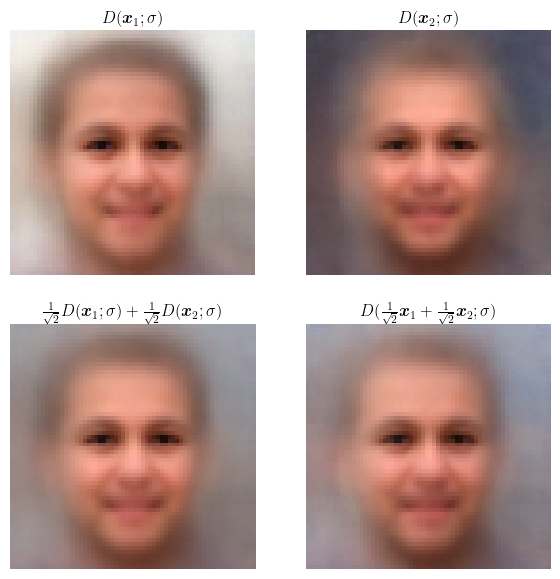

sigma = 9.72320135526013


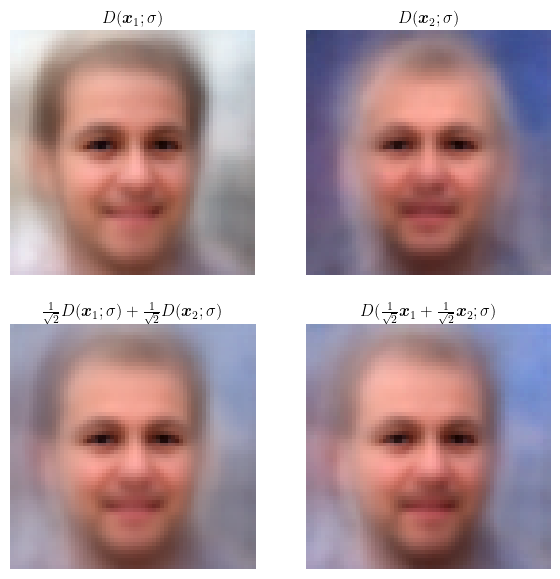

sigma = 4.066123602953759


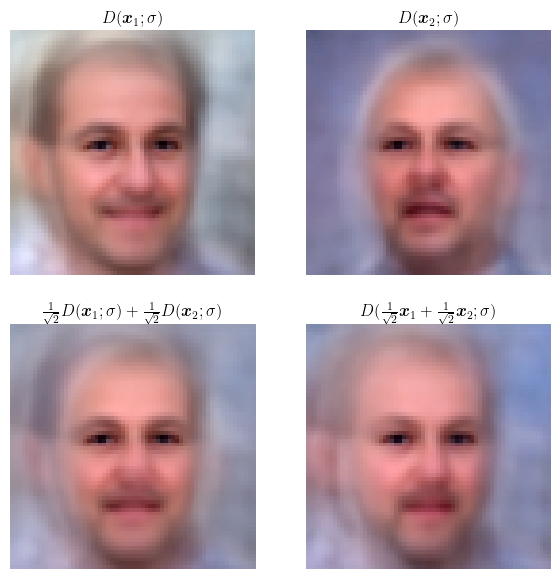

sigma = 1.501741979068008


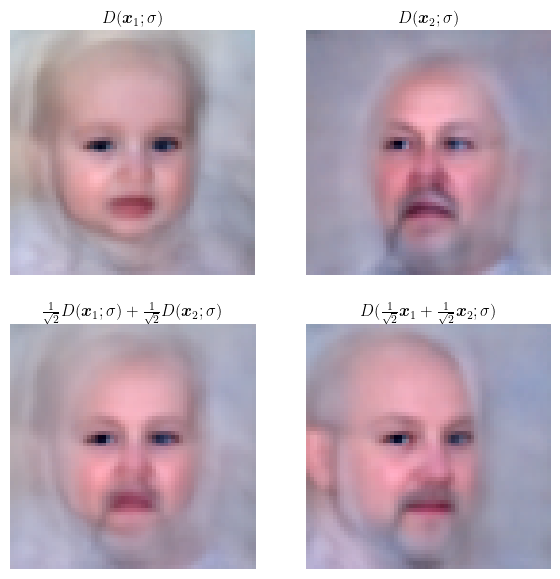

sigma = 0.46997905799774714


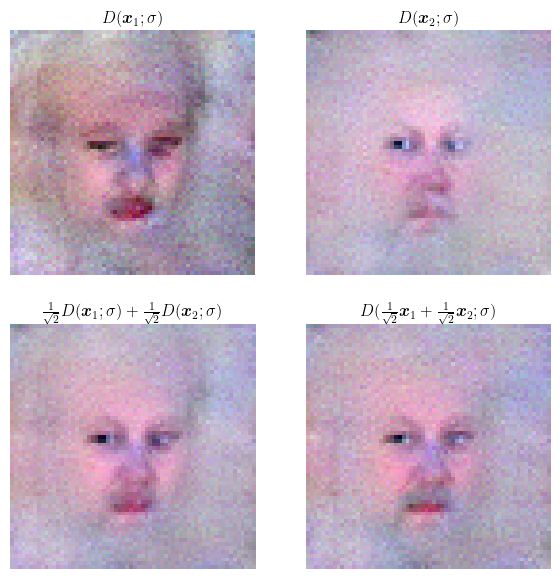

sigma = 0.11663856352517865


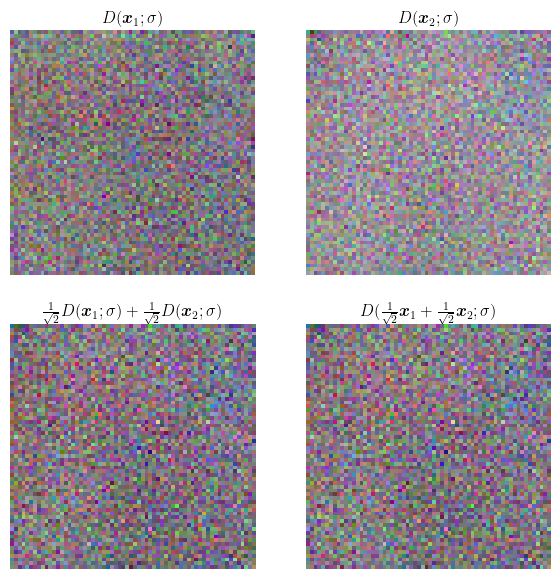

sigma = 0.020435334553438746


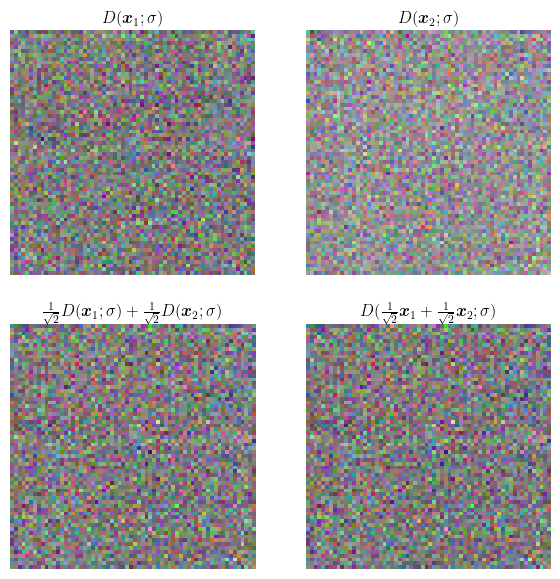

sigma = 0.002000000000000003


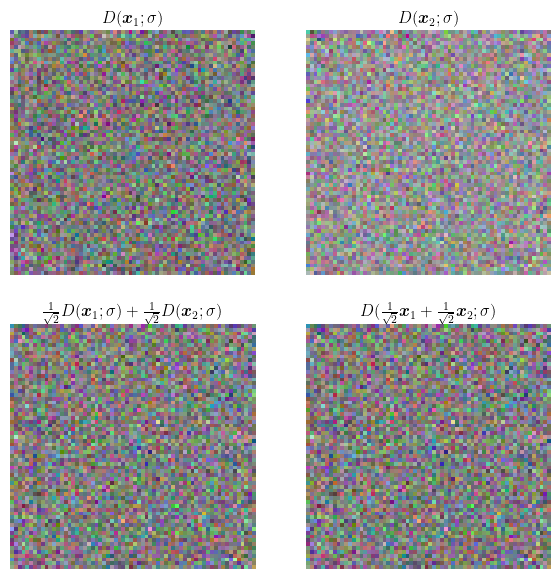

In [135]:
torch.manual_seed(2)
noise_1 = torch.randn(1,3,64,64).to(device)
noise_2 = torch.randn(1,3,64,64).to(device)
device = torch.device('cuda')

sigmas = [80.0,
 42.415189318512674,
 21.10867673619376,
 9.72320135526013,
 4.066123602953759,
 1.501741979068008,
 0.46997905799774714,
 0.11663856352517865,
 0.020435334553438746,
 0.002000000000000003]
alpha = 0.5
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{bm}')
for i in range(len(sigmas)):
    sigma = sigmas[i]
    denoised_img_1 = get_denoised_img(sigma*noise_1, net, sigma)
    denoised_img_2 = get_denoised_img(sigma*noise_2, net, sigma)
    noise_additive = np.sqrt(alpha)*noise_1 + np.sqrt(1-alpha)*noise_2
    denoised_img_additive = get_denoised_img(sigma*noise_additive, net, sigma)
    print('sigma =',sigma)
    plt.figure(figsize=(7,7))
    plt.subplot(221)
    plt.title(r'$D(\bm{x}_1;\sigma)$')
    plt.imshow(normalize_img(denoised_img_1[0]).detach().cpu().permute(1,2,0).numpy())
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
    plt.subplot(222)
    plt.title(r'$D(\bm{x}_2;\sigma)$')
    plt.imshow(normalize_img(denoised_img_2[0]).detach().cpu().permute(1,2,0).numpy())
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
    plt.subplot(223)
    plt.title(r'$\frac{1}{\sqrt{2}} D(\bm{x}_1;\sigma) + \frac{1}{\sqrt{2}} D(\bm{x}_2;\sigma)$')
    plt.imshow(normalize_img(np.sqrt(alpha)*denoised_img_1[0] + np.sqrt(1-alpha)*denoised_img_2[0]).detach().cpu().permute(1,2,0).numpy())
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
    plt.subplot(224)
    plt.title(r'$D(\frac{1}{\sqrt{2}}\bm{x}_1+\frac{1}{\sqrt{2}}\bm{x}_2;\sigma)$')
    plt.imshow(normalize_img(denoised_img_additive[0]).detach().cpu().permute(1,2,0).numpy())    
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
    plt.show()

## Choice 2: take noisy image as input

/tmp/ipykernel_412733/1948042587.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return net(noisy_img, torch.tensor(var,device=device))


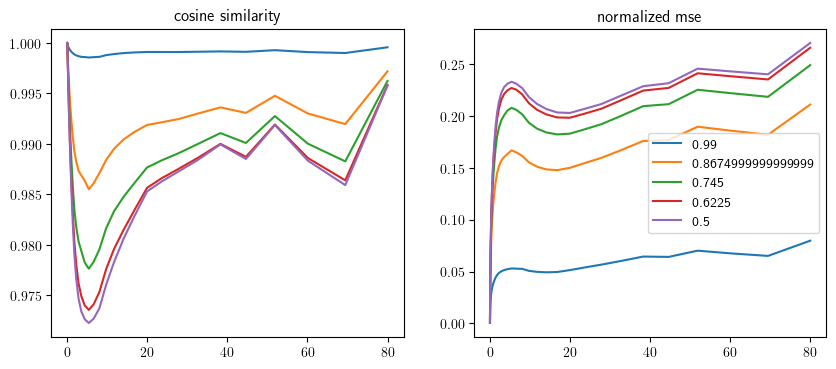

In [136]:
torch.manual_seed(0)

cos_similarity_list_all = []
normalized_mse_list_all = []
batch_size = 100
alphas = np.linspace(0.99,1/2,5)

data_1 = dataset_celeb[0:batch_size].reshape(batch_size,3,64,64)

data_2 = dataset_celeb[batch_size:2*batch_size].reshape(batch_size,3,64,64)
noise_1 = torch.randn(batch_size,3,64,64).to(device)
noise_2 = torch.randn(batch_size,3,64,64).to(device)
for alpha in alphas:
    cos_similarity_list = []
    normalized_mse_list = []
    for sigma in t_steps:
        denoised_img_1 = get_denoised_img(data_1+sigma*noise_1, net, sigma)
        denoised_img_2 = get_denoised_img(data_2+sigma*noise_2, net, sigma)
        img_additive = np.sqrt(alpha)*(data_1+sigma*noise_1) + np.sqrt(1-alpha)*(data_2+sigma*noise_2)
        denoised_img_additive = get_denoised_img(img_additive, net, sigma)
        cos_similarity_list.append(cosine_similarity(denoised_img_additive, np.sqrt(alpha)*denoised_img_1 + np.sqrt(1-alpha)*denoised_img_2))
        normalized_mse_list.append(normalized_difference(denoised_img_additive, np.sqrt(alpha)*denoised_img_1 + np.sqrt(1-alpha)*denoised_img_2))
    cos_similarity_list_all.append(cos_similarity_list)
    normalized_mse_list_all.append(normalized_mse_list)
    
# Save the linearity scores
'''
save_dir = 'Linear_Investigation/Noisy_Image'
if os.path.exists(save_dir) == False:
    os.makedirs(save_dir)
torch.save(cos_similarity_list_big, os.path.join(save_dir, 'cos_similarity_list'))
torch.save(normalized_mse_list_big, os.path.join(save_dir, 'normalized_mse_list'))
'''

# Visualize the linearity scores
plt.figure(figsize=(10,4))
for i in range(len(cos_similarity_list_all)):
    plt.subplot(121)
    plt.title('cosine similarity')
    plt.plot(t_steps.cpu(), cos_similarity_list_all[i], label=str(alphas[i]))
    plt.subplot(122)
    plt.title('normalized mse')
    plt.plot(t_steps.cpu(), normalized_mse_list_all[i], label=str(alphas[i]))
plt.legend()
plt.show()

## Visualization

sigma = 80.0


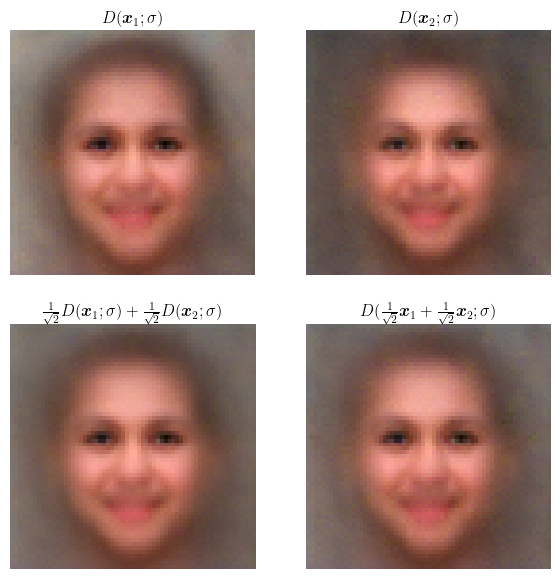

sigma = 42.415189318512674


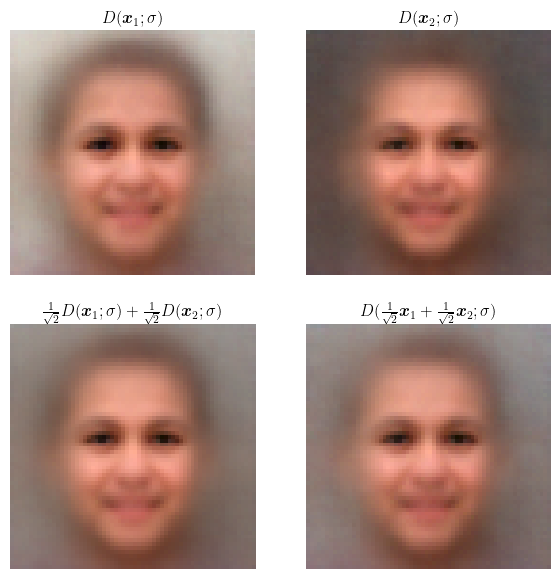

sigma = 21.10867673619376


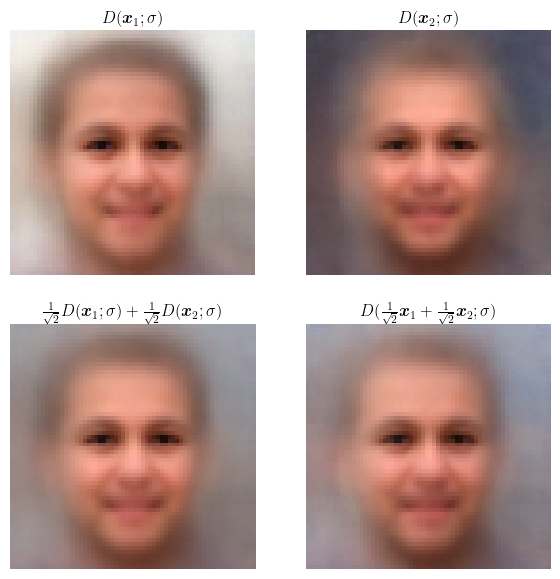

sigma = 9.72320135526013


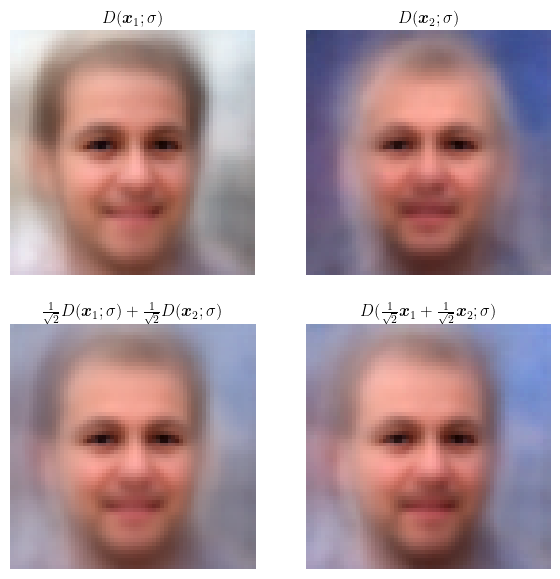

sigma = 4.066123602953759


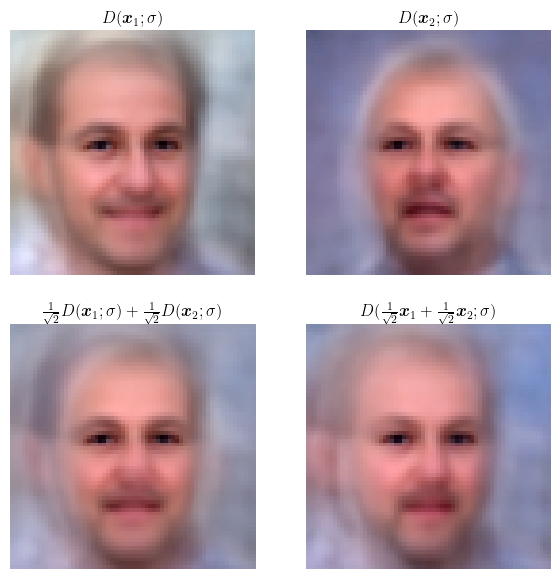

sigma = 1.501741979068008


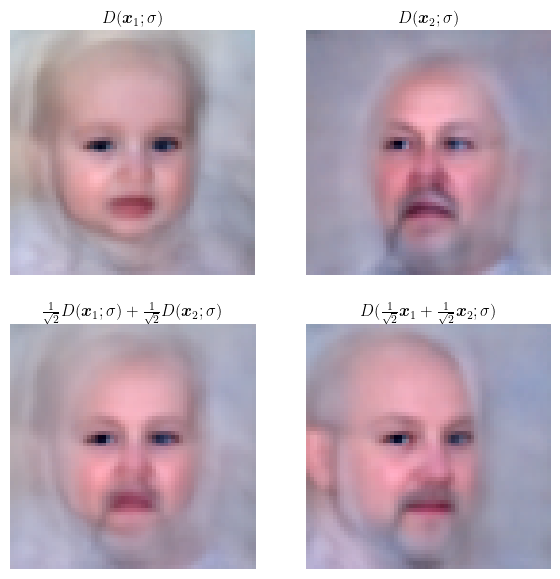

sigma = 0.46997905799774714


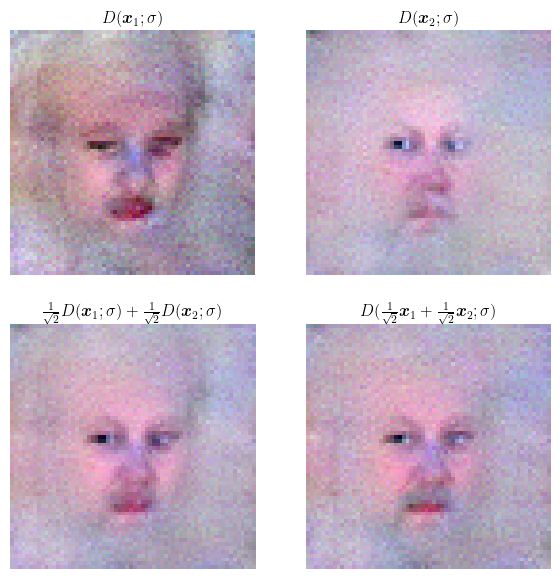

sigma = 0.11663856352517865


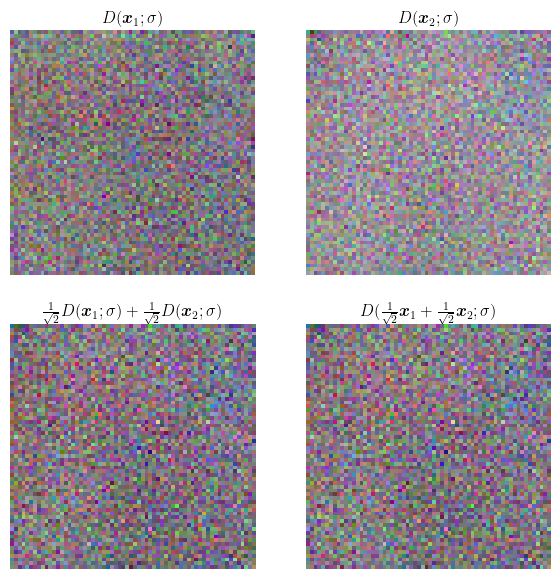

sigma = 0.020435334553438746


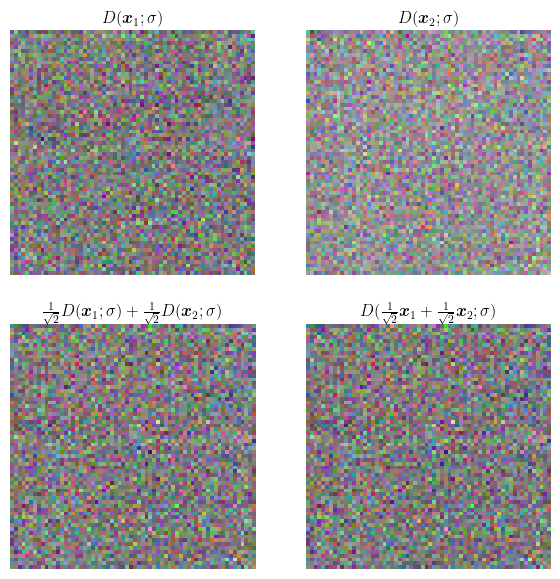

sigma = 0.002000000000000003


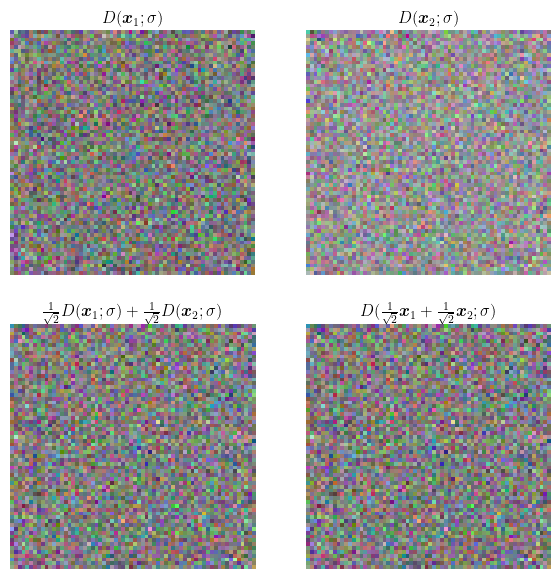

In [137]:
torch.manual_seed(2)
noise_1 = torch.randn(1,3,64,64).to(device)
noise_2 = torch.randn(1,3,64,64).to(device)
device = torch.device('cuda')

sigmas = [80.0,
 42.415189318512674,
 21.10867673619376,
 9.72320135526013,
 4.066123602953759,
 1.501741979068008,
 0.46997905799774714,
 0.11663856352517865,
 0.020435334553438746,
 0.002000000000000003]
alpha = 0.5
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{bm}')
for i in range(len(sigmas)):
    sigma = sigmas[i]
    denoised_img_1 = get_denoised_img(sigma*noise_1, net, sigma)
    denoised_img_2 = get_denoised_img(sigma*noise_2, net, sigma)
    noise_additive = np.sqrt(alpha)*noise_1 + np.sqrt(1-alpha)*noise_2
    denoised_img_additive = get_denoised_img(sigma*noise_additive, net, sigma)
    print('sigma =',sigma)
    plt.figure(figsize=(7,7))
    plt.subplot(221)
    plt.title(r'$D(\bm{x}_1;\sigma)$')
    plt.imshow(normalize_img(denoised_img_1[0]).detach().cpu().permute(1,2,0).numpy())
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
    plt.subplot(222)
    plt.title(r'$D(\bm{x}_2;\sigma)$')
    plt.imshow(normalize_img(denoised_img_2[0]).detach().cpu().permute(1,2,0).numpy())
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
    plt.subplot(223)
    plt.title(r'$\frac{1}{\sqrt{2}} D(\bm{x}_1;\sigma) + \frac{1}{\sqrt{2}} D(\bm{x}_2;\sigma)$')
    plt.imshow(normalize_img(np.sqrt(alpha)*denoised_img_1[0] + np.sqrt(1-alpha)*denoised_img_2[0]).detach().cpu().permute(1,2,0).numpy())
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
    plt.subplot(224)
    plt.title(r'$D(\frac{1}{\sqrt{2}}\bm{x}_1+\frac{1}{\sqrt{2}}\bm{x}_2;\sigma)$')
    plt.imshow(normalize_img(denoised_img_additive[0]).detach().cpu().permute(1,2,0).numpy())    
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
    plt.show()

In [ ]:
torch.manual_seed(0)
noise_1 = torch.randn(1,3,64,64).to(device)
noise_2 = torch.randn(1,3,64,64).to(device)
data_1 = dataset_celeb[1000].reshape(1,3,64,64)
data_2 = dataset_celeb[2000].reshape(1,3,64,64)
device = torch.device('cuda')

sigmas = [80.0,
 42.415189318512674,
 21.10867673619376,
 9.72320135526013,
 4.066123602953759,
 1.501741979068008,
 0.46997905799774714,
 0.11663856352517865,
 0.020435334553438746,
 0.002000000000000003]
alpha = 0.5
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{bm}')
for i in range(len(sigmas)):
    sigma = sigmas[i]
    denoised_img_1 = get_denoised_img(data_1+sigma*noise_1, net, sigma)
    denoised_img_2 = get_denoised_img(data_2+sigma*noise_2, net, sigma)
    img_additive = np.sqrt(alpha)*(data_1+sigma*noise_1) + np.sqrt(1-alpha)*(data_2+sigma*noise_2)
    denoised_img_additive = get_denoised_img(img_additive, net, sigma)
    print('sigma =',sigma)
    plt.figure(figsize=(7,7))
    plt.subplot(221)
    plt.title(r'$D(\bm{x}_1;\sigma)$')
    plt.imshow(normalize_img(denoised_img_1[0]).detach().cpu().permute(1,2,0).numpy())
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
    plt.subplot(222)
    plt.title(r'$D(\bm{x}_2;\sigma)$')
    plt.imshow(normalize_img(denoised_img_2[0]).detach().cpu().permute(1,2,0).numpy())
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
    plt.subplot(223)
    plt.title(r'$\frac{1}{\sqrt{2}} D(\bm{x}_1;\sigma) + \frac{1}{\sqrt{2}} D(\bm{x}_2;\sigma)$')
    plt.imshow(normalize_img(np.sqrt(alpha)*denoised_img_1[0] + np.sqrt(1-alpha)*denoised_img_2[0]).detach().cpu().permute(1,2,0).numpy())
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
    plt.subplot(224)
    plt.title(r'$D(\frac{1}{\sqrt{2}}\bm{x}_1+\frac{1}{\sqrt{2}}\bm{x}_2;\sigma)$')
    plt.imshow(normalize_img(denoised_img_additive[0]).detach().cpu().permute(1,2,0).numpy())    
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
    plt.show()

### The above results demonstrate that diffusion models are highly linear for both high-noise reigme and low-noise regime. The diffusion models are quite nonlinear in the intermediate noise regime, which contributes the most to the perceptual quality of the final samples. Despite the nonlinearity, we will demonstrate that as model transition from memorization to generalization (gradually increasing the training dataset size), this nonlinear regime exhibits increasing linearity as well.

/tmp/ipykernel_412733/1948042587.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return net(noisy_img, torch.tensor(var,device=device))


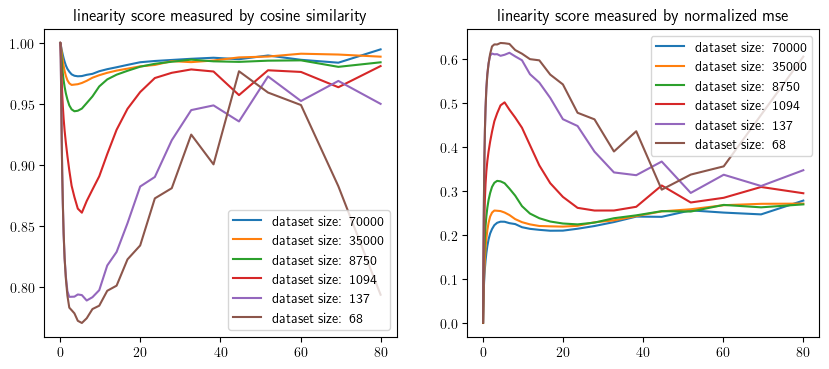

In [140]:
# Network list, we train the diffusion model with fixed scale 128 on datasets with sizes [70000, 35000, 8750, 1094, 137, 68].
# Diffusion models transition from memorization to generalization as the training dataset size increases.
network_pkl_list = ['Varying_dataset_size/FFHQ/70000_scale_128/edm-ffhq-64x64-uncond-ve.pkl',
               'Varying_dataset_size/FFHQ/35000_scale_128/network-snapshot-070246.pkl',
               'Varying_dataset_size/FFHQ/8750_scale_128/network-snapshot-070246.pkl',
               'Varying_dataset_size/FFHQ/1094_scale_128/network-snapshot-070246.pkl',
               'Varying_dataset_size/FFHQ/137_scale_128/network-snapshot-070246.pkl',
               'Varying_dataset_size/FFHQ/68_scale_128/network-snapshot-070246.pkl']

data_1 = dataset_celeb[0:batch_size].reshape(batch_size,3,64,64)

data_2 = dataset_celeb[batch_size:2*batch_size].reshape(batch_size,3,64,64)
noise_1 = torch.randn(batch_size,3,64,64).to(device)
noise_2 = torch.randn(batch_size,3,64,64).to(device)

alpha = 0.5 

cos_similarity_list_all = []
normalized_mse_list_all = []

for network_pkl in network_pkl_list:
    with dnnlib.util.open_url(network_pkl) as f:
        net = pickle.load(f)['ema'].to(device)
        
    cos_similarity_list = []
    normalized_mse_list = []
    for sigma in t_steps:
        denoised_img_1 = get_denoised_img(data_1+sigma*noise_1, net, sigma)
        denoised_img_2 = get_denoised_img(data_2+sigma*noise_2, net, sigma)
        img_additive = np.sqrt(alpha)*(data_1+sigma*noise_1) + np.sqrt(1-alpha)*(data_2+sigma*noise_2)
        denoised_img_additive = get_denoised_img(img_additive, net, sigma)
        cos_similarity_list.append(cosine_similarity(denoised_img_additive, np.sqrt(alpha)*denoised_img_1 + np.sqrt(1-alpha)*denoised_img_2))
        normalized_mse_list.append(normalized_difference(denoised_img_additive, np.sqrt(alpha)*denoised_img_1 + np.sqrt(1-alpha)*denoised_img_2))
    cos_similarity_list_all.append(cos_similarity_list)
    normalized_mse_list_all.append(normalized_mse_list)

# dataset_sizes = [70000, 35000, 8750, 1094, 137, 68]
# Visualize the linearity scores
plt.figure(figsize=(10,4))
plt.subplot(121)
for i in range(len(cos_similarity_list_all)):
    plt.plot(t_steps.cpu(), cos_similarity_list_all[i], label='dataset size: '+str(dataset_sizes[i]))
    plt.title('linearity score measured by cosine similarity')
plt.legend()

plt.subplot(122)
for i in range(len(normalized_mse_list_all)):
    plt.plot(t_steps.cpu(), normalized_mse_list_all[i], label='dataset size: '+str(dataset_sizes[i]))
    plt.title('linearity score measured by normalized mse')
    
plt.legend()
plt.show()

### The above results demonstrate that as diffusion models transition from memorization to generalization, which is achieved by increasing the training dataset size, the corresponding diffusion denoisers exhibit increasing linearity. This motivates us to ask what kind of linear function is learned by the diffusion denoisers? It turns out such linear function is the optimal denoiser for a Multivariate Gaussian characterized by the empirical mean and empirical covariance of the training dataset.  We demonstrate this point by using linear (affine) models to approximate the input-output function mappings of the diffusion denoisers. These models can be thought of as the linear estimation of the nonlinear diffusion denoisers. Interestingly, as we've shown in the paper, the optimal linear estimations are approximately equivalent to the optimal denoisers under the Gaussian data assumption.  We'd like to remark that this phenomenon is nontrivial.

### Though Theorem 1 in the paper implies if we directly train linear diffusion models using the denosing score matching loss, we will get the Gaussian denoisers, here we are instead using linear models to approximate trained nonlinear diffusion models. In general, suppose we have the ground truth score function of a non-Gaussian distribution and then use a linear (affine) model to approximate it, the corresponding optimal linear model won't be the same as the optimal denoiser for the Gaussian distribution characterized by the mean and covariance of the non-Gaussian distribution.

### Below, we give instructions on how to train the linear models. We consider 10 discrete timesteps, therefore, for one nonlinear diffusion models we train 10 separate linear models. Then we chain the 10 models together to perform sampling. Importantly, different noise levels require different learning rate to be trained correctly. For edm-vp trained on FFHQ, the best learning rates are: (80, 5e-5), (42.4152, 5e-5), (21.1087, 5e-05), (9.7232, 5e-05), (4.0661, 5e-05), (1.5017, 5e-04), (0.47, 5e-04), (0.1166, 5e-03), (0.0204, 5e-2), (0.002, 5e-2). The training is computationally expensive, and should not be performed using the jupyter notebook. We suggest users to adapt the code below to a separate python script and perform training on clusters.

In [4]:
# Step 1: Define the linear models
class LinearModel(nn.Module):
    def __init__(self, input_dim, sigma, temperature=1):
        super(LinearModel, self).__init__()
        self.linear_mapping = nn.Linear(input_dim, input_dim)
        nn.init.constant_(self.linear_mapping.bias, 0)
        nn.init.constant_(self.linear_mapping.weight, 0)
        self.sigma =  sigma
        self.temp = temperature
        self.input_dim = input_dim

    def forward(self, queries):
        queries = queries/(self.temp*self.input_dim ** 0.5)
        output = self.linear_mapping(queries)
        return output
    
# Step 2: Run the following command to perform training (Impotantly, different noise levels require different learning rate):
'''
python train_linear_model.py --sigma 80.0 --lr 5e-05 --epochs 100 --network_pkl_final https://nvlabs-fi-cdn.nvidia.com/edm/pretrained/edm-ffhq-64x64-uncond-vp.pkl \
                             --image_path datasets/'datasets/celeb_hq_64x64.zip' -- input_dim 3*64*64
'''

# Step 3: Perform sampling using linear models
# (i) put the 10 linear models in a list
model_list = ['Linear_FFHQ/80.0/noisy_image_distillation_cifar/5e-05/weights99.pt',
              'Linear_FFHQ/42.4152/noisy_image_distillation_cifar/5e-05/weights99.pt',
              'Linear_FFHQ/21.1087/noisy_image_distillation_cifar/5e-05/weights99.pt',
              'Linear_FFHQ/9.7232/noisy_image_distillation_cifar/5e-05/weights99.pt',
              'Linear_FFHQ/4.0661/noisy_image_distillation_cifar/5e-05/weights99.pt',
              'Linear_FFHQ/1.5017/noisy_image_distillation_cifar/0.0005/weights99.pt',
              'Linear_FFHQ/0.47/noisy_image_distillation_cifar/0.0005/weights99.pt',
              'Linear_FFHQ/0.1166/noisy_image_distillation_cifar/0.005/weights99.pt',
              'Linear_FFHQ/0.0204/noisy_image_distillation_cifar/0.05/weights99.pt',
              'Linear_FFHQ/0.002/noisy_image_distillation_cifar/0.05/weights99.pt']

# (ii) define the linear sampler:
def generate_image_linear(
    net, latents , model_list, input_dim=3*64*64, even_t=False, num_steps=10, sigma_min=0.002, sigma_max=80, rho=7,
    S_churn=0, S_min=0, S_max=float('inf'), S_noise=1, device=torch.device('cuda')):
    
    sigma_list = []
    intermediates = []
    denoised_intermediates = []
    
    # Pick latents and labels.
    batch_size = latents.shape[0]
    class_labels = None
    if net.label_dim:
        class_labels = torch.eye(net.label_dim, device=device)[torch.randint(net.label_dim, size=[batch_size], device=device)]

    # Adjust noise levels based on what's supported by the network.
    sigma_min = max(sigma_min, net.sigma_min)
    sigma_max = min(sigma_max, net.sigma_max)

    # Time step discretization.
    step_indices = torch.arange(num_steps, dtype=torch.float64, device=device)
    t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
    if even_t == True:
        t_steps = torch.from_numpy(np.linspace(sigma_max, sigma_min, num_steps)).to(device)
    t_steps = torch.cat([net.round_sigma(t_steps), torch.zeros_like(t_steps[:1])]) # t_N = 0

    # Main sampling loop.
    x_next = latents.to(torch.float32) * t_steps[0]
    
    # Construct linear model
    linear_model = LinearModel(input_dim=input_dim, sigma=None).to(device)
    for i, (t_cur, t_next) in tqdm.tqdm(list(enumerate(zip(t_steps[:-1], t_steps[1:]))), unit='step'): # 0, ..., N-1

        linear_model.load_state_dict(torch.load(model_list[i]))
        x_cur = x_next

        # Increase noise temporarily.
        gamma = min(S_churn / num_steps, np.sqrt(2) - 1) if S_min <= t_cur <= S_max else 0
        t_hat = net.round_sigma(t_cur + gamma * t_cur)
        x_hat = x_cur + (t_hat ** 2 - t_cur ** 2).sqrt() * S_noise * torch.randn_like(x_cur)

        # Euler step.
        denoised = linear_model(x_hat)
        d_cur = (x_hat - denoised) / t_hat
        x_next = x_hat + (t_next - t_hat) * d_cur
        '''
        # Apply 2nd order correction.
        if i < num_steps - 1:
            denoised = net(x_next, t_next, class_labels).to(torch.float64)
            d_prime = (x_next - denoised) / t_next
            x_next = x_hat + (t_next - t_hat) * (0.5 * d_cur + 0.5 * d_prime)
        '''
        intermediates.append(x_cur.detach().cpu())
        denoised_intermediates.append(denoised.detach().cpu())
        sigma_list.append(t_cur.item())
        #del linear_model
        
    # Save image grid.
    return sigma_list, intermediates, denoised_intermediates

# (iii) perform sampling with linear models
device = torch.device('cuda')
net_pkl = 'https://nvlabs-fi-cdn.nvidia.com/edm/pretrained/edm-ffhq-64x64-uncond-vp.pkl'
with dnnlib.util.open_url(net_pkl) as f:
    net = pickle.load(f)['ema'].to(device)

latents = torch.randn(20,3,64,64).to(device)
sigma_list, intermediates_linear, denoised_intermediates_linear = generate_image_linear(net, latents.reshape(-1,3*64*64) ,num_steps=10, sigma_min=0.002, sigma_max=80, rho=7,S_churn=0, S_min=0, S_max=float('inf'), S_noise=0, device=device)

# (iv) visualize the samples
plt.figure(figsize=(20, 2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(normalize_img(denoised_intermediates_linear[i][idx].reshape(3,64,64).permute(1,2,0)))
    if i==0:
        plt.ylabel('Linear', fontsize=axis_label_size)
    plt.xticks([])
    plt.yticks([])
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
#plt.tight_layout()
plt.show()